## Packages 

In [1]:
import numpy as np
print("numpy version:", np.__version__)
import pandas as pd
print("pandas version:", pd.__version__)

import scipy
print("scipy version:", scipy.__version__)
from scipy.spatial.distance import cdist
from scipy.linalg import cholesky
from scipy.stats import *

import statsmodels.api as sm
print("statsmodels version:", sm.__version__)

import keras
print("keras version:", keras.__version__)
from keras.layers import Dense, Dropout, Flatten, SpatialDropout2D, SpatialDropout1D, AlphaDropout, Conv2D, \
    MaxPooling2D 


import multiprocessing
print("multiprocess version:", 3.12)
from multiprocessing import Pool
import functools
print("functools version:", 3.8)
from functools import partial

numpy version: 1.19.5
pandas version: 1.2.1
scipy version: 1.6.0
statsmodels version: 0.12.1
keras version: 2.4.3
multiprocess version: 3.12
functools version: 3.8


## Functions for generating simulation datasets 

### features_from_image = $\boldsymbol{\Phi}$
### covariateMat = $\mathbf{Z}$ 
### true_beta_vec = $\boldsymbol{\gamma}$, c(1,1)
### Zmat_intensity =  $\boldsymbol{\lambda}=g^{-1}(\boldsymbol{\Phi}+\mathbf{Z}\boldsymbol{\gamma})$

In [2]:
def make_grid(grid_shape_tuple):
    gridLoc = []
    for i in range(grid_shape_tuple[0]):
        for j in range(grid_shape_tuple[1]):
            gridLoc.append([i, j])
    return gridLoc


def gp_image_generator(num_image, grid_shape_tuple, matern_param_dict, seed_val):

    # set the places
    randGenerator = np.random.default_rng(seed=seed_val)
    gridLoc = make_grid(grid_shape_tuple)

    # Matern covariance structure seting
    if "phi" not in matern_param_dict.keys():
        print('hi')
        raise KeyError("matern_param_dict should include the parameter key:value pair -> 'phi':x")
    if "sigma2" not in matern_param_dict.keys():
        raise KeyError("matern_param_dict should include the parameter key:value pair -> 'sigma2':x")

    distMatLoc = cdist(gridLoc, gridLoc, 'euclidean')
    MaternCov_mat = (1 + (5 ** 0.5 * distMatLoc / matern_param_dict["phi"]) + (5 * distMatLoc ** 2) / (
            3 * matern_param_dict["phi"] ** 2)) * \
                    np.exp(-(5 ** 0.5 * (distMatLoc / matern_param_dict["phi"])))
    MaternCov_mat *= matern_param_dict["sigma2"]

    # generate images
    image_list = []
    image_mean = []
    for _ in range(num_image):
        MaternCov_TSseed = randGenerator.normal(loc=0.0, scale=1.0, size=MaternCov_mat.shape[0])
        gp_image = np.matmul(cholesky(MaternCov_mat).T, MaternCov_TSseed)
        gp_image_vector_form = np.array(gp_image)
        gp_image_matrix_form = np.reshape(gp_image_vector_form, grid_shape_tuple)
        image_list.append(gp_image_matrix_form)  
        image_mean.append(np.mean(gp_image_matrix_form))


    return np.array(image_list), np.array(image_mean)


def image_filter_generator(loc_knots, grid_shape_tuple, basis="invQuad", **kwargs):

    gridLoc = np.array(make_grid(grid_shape_tuple))
    distMat_knot_grid = np.array(cdist(loc_knots, gridLoc, 'euclidean'))


    # invQuadBasis
    if basis == "invQuad":
        if "phi" in kwargs.keys():
            phi = kwargs["phi"]
        else:
            raise ValueError("please put additional argument 'phi' to control the decay of this kernel")
        basis_mat = 1 / (1 + (phi * distMat_knot_grid) ** 2)

    else:
        raise ValueError("the basis is not yet implemented:", basis)
    basis_mat = np.reshape(basis_mat, (len(loc_knots), grid_shape_tuple[0], grid_shape_tuple[1]))
    return basis_mat


def image_transformer(image_array, filter_array):

    feature_list = []
    for image in image_array:
        for filt in filter_array:
            filtered_image = image * filt
            feature_list.append(np.mean(filtered_image))
    feature_array = np.array(feature_list)
    feature_array = np.reshape(feature_array, (len(image_array), len(filter_array)))
    return feature_array


def get_dropout(input_tensor, p=0.5, mc=False):
    if mc:
        return Dropout(p)(input_tensor, training=True)
    else:
        return Dropout(p)(input_tensor)


def simulation_data_generator(num_data, true_beta_vec, image_shape, seed_val):
    image_array, image_mean = gp_image_generator(num_data, grid_shape_tuple=image_shape,
                                                 matern_param_dict={"phi": 15, "sigma2": 1},
                                                 seed_val=seed_val * 10) 

    basis_array = image_filter_generator([[0, 0], [30, 30], [10, 20], [15, 15]], grid_shape_tuple=image_shape,
                                         basis="invQuad", phi=0.1)  # normal, binary
    
#     basis_array = image_filter_generator([[30, 30], [10, 20]], grid_shape_tuple=image_shape,
#                                          basis="invQuad", phi=0.1) # poisson


    features_from_image = image_transformer(image_array, basis_array)

    randGenerator = np.random.default_rng(seed=seed_val)
    covariateMat = randGenerator.normal(loc=0.0, scale=1.0, size=(num_data, len(true_beta_vec)))

    # normal
#     Zmat_intensity = np.matmul(covariateMat, true_beta_vec) + np.matmul(features_from_image,
#                                                                         np.ones(features_from_image.shape[1]))  
#     responseVec = np.random.normal(loc=Zmat_intensity, scale=1)
  
    # poisson 
#     Zmat_intensity = np.exp(np.matmul(covariateMat, true_beta_vec) + np.matmul(features_from_image, np.ones(features_from_image.shape[1])))  
#     responseVec = np.random.poisson(lam=Zmat_intensity)


    # binary 
    Zmat_intensity = 1 / (1 + np.exp(-(np.matmul(covariateMat, true_beta_vec) + np.matmul(features_from_image,
                                                                                          np.ones(features_from_image.shape[1])))))
    responseVec = np.random.binomial(1, Zmat_intensity)


    return covariateMat, image_array, responseVec, Zmat_intensity


## BayesCNN model

In [7]:
def get_model(mc=False, act="relu"):
    from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, concatenate
    from keras.models import Sequential, Model, Input, load_model
    from keras.layers import Dense, Dropout, Flatten, SpatialDropout2D, SpatialDropout1D, AlphaDropout, Conv2D, \
        MaxPooling2D, Conv1D, MaxPooling1D
    from tensorflow.keras.optimizers import Adam

    inp = Input((30, 30, 1))
    other_input = Input((2,))
    x = Conv2D(16,
               kernel_size=(3, 3),    # (4,4) for normal/poisson case,  (3,3) for binary case 
               strides=(1, 1),        # (2,2) for normal/poisson case,  (1,1) for binary case 
               activation='softmax')(inp)
    x = get_dropout(x, p=0.25, mc=mc) # p=0.2 for normal/poisson case, p=0.25 for binary case
    x = MaxPooling2D()(x)
    x = Conv2D(32,                  # 16 for normal case, 32 for binary/poisson case
               kernel_size=(3, 3),  # (3,3) for normal/binary/poisson 
               strides=(1, 1),      # (2,2) for normal case,  (1,1) for binary/poisson case 
               activation='softmax')(x)
    x = get_dropout(x, p=0.25, mc=mc)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(16, activation='relu')(x)
    x = get_dropout(x, p=0.25, mc=mc)
    x = Dense(8, activation='linear')(x) # 16 (linear) for normal/pisson case, 8(linear) for binary case  
    x = get_dropout(x, p=0.25, mc=mc)
#     x = Dense(16, activation='softplus')(x) # 16 (softplus) for normal case
#     x = get_dropout(x, p=0.2, mc=mc)
    x = concatenate([x, other_input])
    out = Dense(1, activation='sigmoid')(x) 
    # (linear) for normal case, (exponential) for poisson case, (sigmoid) for binary case 

    model = Model(inputs=[inp, other_input], outputs=out)

    model.compile(optimizer=Adam(learning_rate=1e-4), # 1e-4 for normal/binary case, 1e-3 for poisson case 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    # (mse, mse) for normal case, (poisson,mse) for poisson case, (binary_crossentropy, accuracy) for binary case  

    return model


## BayesCGLM model

In [4]:
def prob2y2(values):
    return [1 if v >= 0.5 else 0 for v in values]

def job(weights, X_input, X_cv, X_train_covariate, X_cv_covariate, Zmat_data, Zmat_cv, idx):
    from keras.models import Sequential, Model, Input, load_model
    mc_model = get_model(mc=True, act="relu")
    mc_model.set_weights(weights)
    model = Model(inputs=mc_model.inputs, outputs=mc_model.layers[10].output)   
    ##### 12th last layer for normal, 10th last layer for poisson/binary 
    rv = model.predict(X_input)
    response = np.array(rv)
    rv_test = model.predict(X_cv)
    response_test = np.array(rv_test)

    x_final = np.hstack([response, X_train_covariate])
    x_final_test = np.hstack([response_test, X_cv_covariate])

    Zmat_train = Zmat_data.reshape(Zmat_data.shape[0], 1)


    x_const_final = sm.add_constant(x_final)
    x_const_final_test = sm.add_constant(x_final_test)
#     _model = sm.GLM(Zmat_train, x_const_final, family=sm.families.Gaussian())
#     _model = sm.GLM(Zmat_train, x_const_final, family=sm.families.Poisson()) # poisson
    _model = sm.GLM(Zmat_train, x_const_final, family=sm.families.Binomial()) #binary
    _results = _model.fit()

    fisher = _model.information(_results.params)
    fisher = - fisher
    fisher_m = np.array(fisher)
    fisher_inf = np.linalg.inv(fisher_m)

    inverse_fisher = fisher_inf[9:, 9:] # binary
#     inverse_fisher = fisher_inf[17:, 17:] # normal/poisson

    fishers = []

    for subject in x_const_final_test:
        ff = np.dot(np.dot(subject, fisher_inf), subject.T)
        fishers.append(ff)

    ## normal/poisson case 
    pred = _results.predict(x_const_final_test)
#     pred_train = _results.predict(x_const_final)
#     error_train = pred_train - Zmat_train
#     mse = np.mean(error_train)
    
    ## binary case 
    ys = prob2y2(pred)
    y_true = np.array(Zmat_cv)
    acc = accuracy_score(y_true, ys)
    rec = recall_score(y_true, ys)
    prc = precision_score(y_true, ys)
    f1 = f1_score(y_true, ys)

    acc = np.hstack([acc, rec, prc, f1])
    
#     return _results.params[-2:], pred, mse, fishers, inverse_fisher  # normal/poisson
    return _results.params[-2:], pred, acc, fishers, inverse_fisher  # binary



## $\color{blue}{\text{Step1.}}$ Generate simulation datasets
### j = seed number for genertaing simulation datasets 

In [54]:
j = 400
covariateMat, image_array, responseVec, Zmat_intensity = simulation_data_generator(1000, [1, 1], (30, 30), j)
ind_data = 700
Zmat_data = responseVec[:ind_data, ]  # 700 x 1
Zmat_cv = responseVec[ind_data:, ]  # 300 x 1

X_train_covariate = covariateMat[:ind_data, :]  # covariate
X_cv_covariate = covariateMat[ind_data:, :]

X_train_basis = image_array[:ind_data, :, :] # basis 700 x 30 x 30
X_cv_basis = image_array[ind_data:, :, :] # basis 300 x 30 x 30

## $\color{blue}{\text{Step2.}}$ Run BayesCNN

In [55]:
batch_size = 32 # 32 for normal case, 3 for binary/poisson case 
epochs = 500  # 300 for nomral case, 2000 for binary/poisson case

mc_model = get_model(mc=True, act="relu")

h_mc = mc_model.fit([X_train_basis, X_train_covariate], Zmat_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=([X_cv_basis, X_cv_covariate], Zmat_cv))


Epoch 1/500
22/22 [==============================] - 2s 40ms/step - loss: 0.8587 - accuracy: 0.3323 - val_loss: 0.8697 - val_accuracy: 0.3133
Epoch 2/500
22/22 [==============================] - 1s 32ms/step - loss: 0.8767 - accuracy: 0.3269 - val_loss: 0.8679 - val_accuracy: 0.3000
Epoch 3/500
22/22 [==============================] - 1s 29ms/step - loss: 0.8795 - accuracy: 0.3117 - val_loss: 0.8660 - val_accuracy: 0.3200
Epoch 4/500
22/22 [==============================] - 1s 31ms/step - loss: 0.8601 - accuracy: 0.3302 - val_loss: 0.8660 - val_accuracy: 0.3200
Epoch 5/500
22/22 [==============================] - 1s 25ms/step - loss: 0.8636 - accuracy: 0.3170 - val_loss: 0.8649 - val_accuracy: 0.3033
Epoch 6/500
22/22 [==============================] - 1s 23ms/step - loss: 0.8787 - accuracy: 0.2987 - val_loss: 0.8642 - val_accuracy: 0.3233
Epoch 7/500
22/22 [==============================] - 1s 26ms/step - loss: 0.8583 - accuracy: 0.3060 - val_loss: 0.8628 - val_accuracy: 0.3300
Epoch 

## $\color{blue}{\text{Step3.}}$ Run BayesCGLM
### n_process = core number of parallel models 
### n_model = MC iterations, $M$

#### About "defs.py": If you wish to implement parallel computing in Jupyter Notebook, you need to import the "defs.py" file, which contains the code for parallel computing of BayesCGLM. Please refer to the uploaded defs.py file for details.

In [56]:
import defs

In [57]:
n_process = 3
n_model = 300

mc_beta = []
mc_predictions_glmm = []
mc_predictions_glmm_train = []

sigma = []
pred_sigma = []
accuracy = []
X_input = [X_train_basis, X_train_covariate]
X_cv = [X_cv_basis, X_cv_covariate]

weights = mc_model.get_weights()


with Pool(processes=n_process) as pool:
    for mc_beta_, mc_predictions_glmm_, mse, pred_sigma_, sigma_ in \
            pool.map(partial(defs.job,
                             weights, X_input, X_cv, X_train_covariate, X_cv_covariate, Zmat_data, Zmat_cv),
                     range(n_model)):
        mc_beta.append(mc_beta_)
        mc_predictions_glmm.append(mc_predictions_glmm_)
        accuracy.append(mse)
        pred_sigma.append(pred_sigma_)
        sigma.append(sigma_)


## $\color{blue}{\text{Step4.}}$ Check outputs
### mc_beta : $\widehat\beta_m$ , $m=1,\cdots,M$
### mc_predictions_glmm : $\widehat{y}_{i,m}$, $i=1,\cdots,N$, $m=1,\cdots,M$

In [58]:
mc_beta_df = pd.DataFrame(mc_beta)
print(mc_beta_df.head(10))

          0         1
0  0.812084  0.959612
1  0.799212  0.962553
2  0.758274  0.952268
3  0.807885  0.954364
4  0.783354  0.942945
5  0.783368  0.969437
6  0.775651  0.960155
7  0.798531  0.943154
8  0.763550  0.969097
9  0.766834  0.954490


## Predictive distribution

* size: number of generating samples from Normal distribution 
* y_dist_final1: Each prediction $i$ contains $size \times M$ number of samples from the predictive distribution 

In [48]:
print("accuracy:", round(np.mean(accuracy, axis=0)[0],2))
print("Recall:", round(np.mean(accuracy, axis=0)[1],2))
print("Precision:", round(np.mean(accuracy, axis=0)[2],2))
print("F1:", round(np.mean(accuracy, axis=0)[3],2))

accuracy: 0.77
Recall: 0.74
Precision: 0.79
F1: 0.76


In [ ]:
size = 10
y_true = pd.DataFrame(Zmat_cv)
posterior_predictive = np.array(mc_predictions_glmm)


n_m, n_c = posterior_predictive.shape
n_mm = n_m

res = np.zeros((n_mm, n_c, size))
for m in range(n_mm):
    for c in range(n_c):
        mean = posterior_predictive[m][c]
        std = np.abs(pred_sigma[m][c])
        samples = norm.rvs(loc=mean, scale=std, size=size, random_state=None)
        for s, v in enumerate(samples):
            res[m][c][s] = v


d1, d2, d3 = res.shape

_res=[]
for i in range(d2):
    _res.append(res[:,i,:].reshape(-1))

_res=np.array(_res)


y_dist_final1 = pd.DataFrame(_res)

print(y_true.shape)
print(y_dist_final1.shape)


### $i$th predictive distribution  

In [ ]:
print("rmspe:", np.mean(accuracy))
# print("standard deviation:", np.std(Zmat_cv))
print(accuracy)

In [ ]:
pred_mean = pd.DataFrame(y_dist_final1.mean(axis=1))
prediction_est = np.hstack([pred_mean,y_true])
name_list = ["pred_hat_mean"] + ["true"]
prediction_est = pd.DataFrame(prediction_est, columns=name_list)
print(prediction_est.head())

In [ ]:
import matplotlib.pyplot as plt
print("matplotlib version:", '3.8.2')

i = 3
plt.hist(_res[i,:],bins=8)
plt.axvline(Zmat_cv[i], color='k', linestyle='dashed', linewidth=1)
plt.show()

## Gamma posterior distribution 

* size: number of generating samples from Normal distribution 
* beta_dist_final1: Each $\gamma$ contains $size \times M$ number of samples from the posterior distribution 

In [49]:
res = []
mc_beta = np.array(mc_beta)
mc_sigma = sigma

n_m = mc_beta.shape[0]

for m in range(n_m):
    mean = mc_beta[m]
    std = mc_sigma[m]
    samples = np.random.multivariate_normal(mean, std, size=size).T
    res.append(samples)

res_array = np.array(res)

res1 = res_array[:,0,:]
res2 = res_array[:,1,:]

b1 = res1.reshape(-1)
b2 = res2.reshape(-1)

b1 = b1.reshape(b1.shape[0], 1)
b2 = b2.reshape(b2.shape[0], 1)


beta_dist_final = np.hstack([b1,b2])
name_list = ["b1"] + ["b2"] 

beta_dist_final1 = pd.DataFrame(beta_dist_final, columns=name_list)

print(beta_dist_final1.shape)


(3000, 2)


### $\gamma$ posterior distribution 

In [50]:
print('\u03B3_1:',  np.mean(beta_dist_final1.loc[:,'b1']))
print('\u03B3_2:',  np.mean(beta_dist_final1.loc[:,'b2']))

γ_1: 1.113362297895613
γ_2: 0.9776722001622467


matplotlib version: 3.8.2


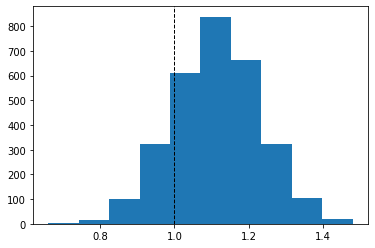

In [52]:
import matplotlib.pyplot as plt
print("matplotlib version:", '3.8.2')
plt.hist(beta_dist_final1.loc[:,'b1'], bins=10)
plt.axvline(1, color='k', linestyle='dashed', linewidth=1)
plt.show()

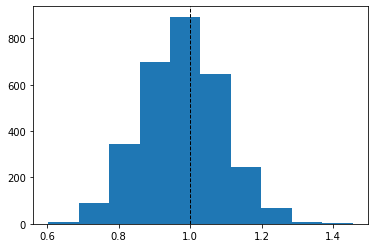

In [53]:
plt.hist(beta_dist_final1.loc[:,'b2'], bins=10)
plt.axvline(1, color='k', linestyle='dashed', linewidth=1)
plt.show()